# 2022 EY Data Science Challenge
## Model Building - Level 1


| Challenge | Locations                     | Spatial Res        | Species     | Satellite Data                                                |
|-----------|-------------------------------|--------------------|-------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (res=1000)  | 23 Species  | TerraClimate                                                  |
| 2         | Australia, Costa Rica         | Moderate (res=100) | 23 Species  | TerraClimate, Sentinel-2                                      |
| 3         | Australia, Costa Rica,<br>Europe | Fine (res=10)   | 23 Species  | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |


In this notebook, we will demonstrate a basic model workflow that can act as a starting point for the challenge. As specified in the first row of the table above, we will restrict this model to regions in Australia at coarse resolution (4kmx4km) with 23 specified species, and predictor variables from [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate) only. In particular, we will be using four features from the TerraClimate dataset, the maximum monthly temperature, the minimum monthly temperature, the mean monthly precipitation, and the mean soil moisture, and will train a logistic regression model with these data. The TerraClimate data is sampled at a monthly temporal resolution, so metrics are calculated over the time dimension to simplify the features. We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 

Most of the functions present in this notebook were adapted from the following notebooks:
- [TerraClimate/Weather](Weather.ipynb)
- [GBIF/Frog](Frogs.ipynb)

Again, it must be noted that this notebook is just a starting point. We make plenty of assumptions in this notebook that you may not think is best for solving the challenge effectively. You are encouraged to modify these functions, to rewrite them completely, or to try a different approach entirely.


In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression

# Geospatial
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
import fsspec

# API
import requests
import json

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer

### Gathering Frog Data

For this demonstration, we will constrain our search to frogs in the Penrith NSW area. This gives a varied landscape of bushland, plains, rivers, and urban areas.

Text(0.5, 1.0, 'Penrith, NSW')

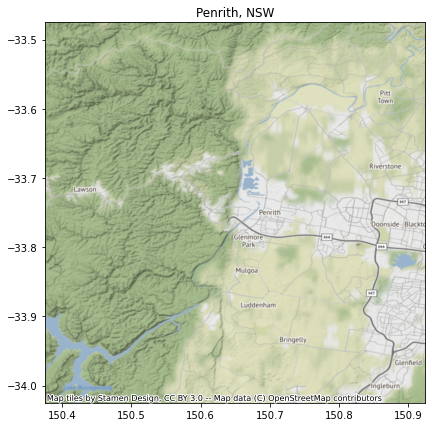

In [2]:
# Penrith, NSW
region_name = 'Penrith, NSW'
min_lon, min_lat = (150.40, -34.00)  # Lower-left corner
max_lon, max_lat = (150.90, -33.50)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Plot map of region
crs = {'init':'epsg:4326'}
fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat], alpha=0)
cx.add_basemap(ax, crs=crs)
ax.set_title(region_name)

#### Fetching Frog Response Variable
Before we can build our model, we need to query the GBIF API to obtain the frog occurrence data for our region. If you have not checked out the [frog notebook](Frogs.ipynb) yet, we recommend you do before moving on so you can better understand the following functions. The code from that notebook is wrapped up in the `get_frogs` function defined below. This function will obtain all frog occurrences for the given region in the five years from the start of 2015 to the end of 2019. It returns a geopandas dataframe of each occurrence, its species, and its latitude and longitude coordinates. The challenge restricts the species to the 23 specified in the ['australian_frogs.csv'](australian_frogs.csv) file. Note that not all 23 will be present for a given area.

In [3]:
def get_frogs(bbox,species_keys, species_names, query_params={}, crs={'init':'epsg:4326'}, order_key="952", verbose=True):
    """Returns the dataframe of frog occurrences for the bounding box specified.
    
    Arguments:
    bbox -- tuple of (min_lon, min_lat, max_lon, max_lat)
    species_keys -- list of species taxonomic keys (keys from gbif database)
    species_names -- list of names associated with species keys
    query_params -- dictionary of query parameters to pass to the GBIF API search function
    crs -- dictionary of the coordinate reference system, defaults to {'init':'epsg:4326'}
    orderKey -- string of the taxonomic key for order, for frogs this is '952'
    verbose -- boolean. If true, will print progress markers 
    """
    # Set query parameters
    min_lon, min_lat, max_lon, max_lat = bbox
    limit = 300
    parameters = {
        **query_params,
        "decimalLatitude":f"{min_lat},{max_lat}", # Latitude range
        "decimalLongitude":f"{min_lon},{max_lon}", # Longitude range
        "limit":limit
    }
    
    frogs = pd.DataFrame()
    for species_name, species_key in zip(species_names, species_keys):
        print(f'Fetching {species_name}, key {species_key}') if verbose else None
        parameters["speciesKey"] = species_key
        
        # Query API
        offset = 0
        while True:
            # Fetch results
            parameters['offset'] = offset
            response = requests.get("https://api.gbif.org/v1/occurrence/search", params = parameters).json()
            total = response['count']
            if total == 0:
                break

            # Print progress
            print(f"{offset} of {total}") if verbose else None

            # Add results to dataframe
            frogs = frogs.append(
                pd.DataFrame(response['results'])
                [["decimalLatitude", "decimalLongitude"]]
                .assign(
                    occurrenceStatus = 1,
                    species = species_name
                )
            )
            if response['endOfRecords']:
                break
            offset += limit
        
    geo_frogs = gpd.GeoDataFrame(
        frogs.reset_index(drop=True), 
        geometry=gpd.points_from_xy(frogs.decimalLongitude, frogs.decimalLatitude),
        crs=crs
    )
    return geo_frogs

In [4]:
# Pass in the date range to the GBIF API
gbif_api_params = {"year":"2015,2019"}

# Read in species data
frog_species = pd.read_csv('australian_frogs.csv')

# Get frogs!
frog_data = get_frogs(bbox, frog_species.speciesKey, frog_species.Species, gbif_api_params, verbose=False)
frog_data.sample(10, random_state=420)

,decimalLatitude,decimalLongitude,occurrenceStatus,species,geometry
88,-33.524281,150.624329,1,Crinia signifera,POINT (150.62433 -33.52428)
1617,-33.735800,150.715000,1,Limnodynastes tasmaniensis,POINT (150.71500 -33.73580)
968,-33.767765,150.743781,1,Crinia signifera,POINT (150.74378 -33.76776)
658,-33.769160,150.481731,1,Crinia signifera,POINT (150.48173 -33.76916)
78,-33.700800,150.572000,1,Crinia signifera,POINT (150.57200 -33.70080)
745,-33.756210,150.623253,1,Crinia signifera,POINT (150.62325 -33.75621)
184,-33.608365,150.884341,1,Crinia signifera,POINT (150.88434 -33.60836)
800,-33.555484,150.422755,1,Crinia signifera,POINT (150.42275 -33.55548)
2204,-33.675900,150.547000,1,Pseudophryne australis,POINT (150.54700 -33.67590)
1236,-33.743000,150.830000,1,Crinia signifera,POINT (150.83000 -33.74300)


Below, we can visualise the frog species distribution of the area. Here, only six of the 23 are present and crinia signifera, the common eastern froglet, is the most common species.

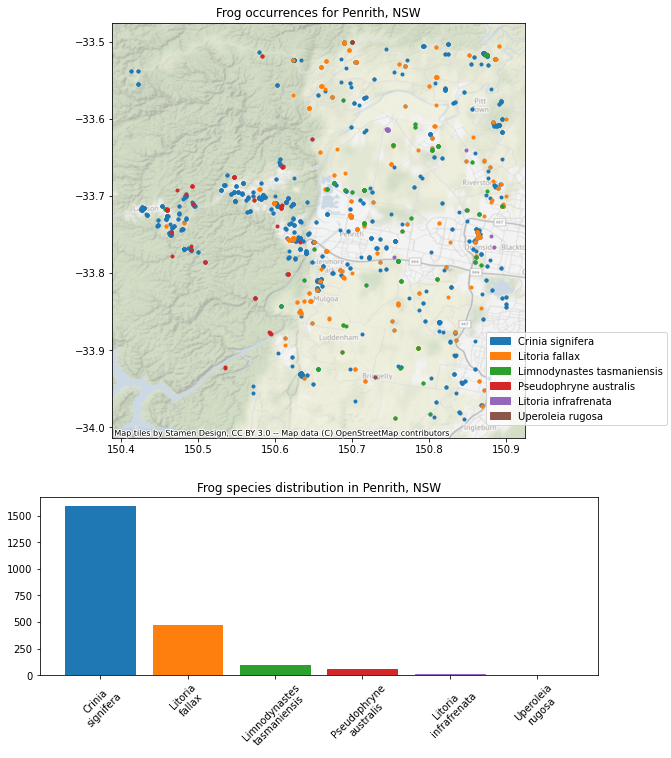

In [5]:
fig, ax = plt.subplots(2, 1, figsize = (10, 12), gridspec_kw={'height_ratios':[0.7, 0.3]})

# Bar chart
bar_data = frog_data.species.value_counts()
barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

# Colour cycle to ensure colors match in both plots
prop_cycle = plt.rcParams['axes.prop_cycle']
for i, color in zip(range(len(bar_data)), prop_cycle):
    species_name = bar_data.index[i]
    barchart[i].set_color(color['color'])
    barchart[i].set_label(species_name)
    filt = frog_data.species == species_name
    # Scatter plot
    ax[0].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, marker='.', color=color['color'])

# Add other features
ax[0].set_title(f"Frog occurrences for {region_name}")
ax[1].set_title(f"Frog species distribution in {region_name}")
cx.add_basemap(ax[0], crs=crs, alpha=0.5) # Add basemap
plt.xticks(rotation=45)
fig.legend(loc='center right')
plt.show()

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success in this challenge.

#### Sampling for Frog Absence
The next step in generating our training data is to sample for where frogs aren't. As mentioned above, the bias in the dataset makes this difficult to do effectively. Just because there is no frog occurrence recorded in an area, does not mean there are no frogs. However, for this demonstration, we will make the assumption that frogs are only present at occurrence locations. Our rather naive method of sampling for frog absence data is wrapped up in the `get_frog_absence` function defined below.

In [6]:
def get_frog_absence(geo_frogs, bbox, crs = {'init':'epsg:4326'}, granularity=(50, 50), seed=420, border=0.05, verbose=True):
    """Returns a dataframe complete with frog-absence data
    
    Finds all grid units with no frogs, and then generates sufficient random points within those grid units to match the number of frogs.
    
    Arguments:
    geo_frogs -- geopandas dataframe of frogs, outputted from get_frogs function
    bbox -- tuple of (min_lon, min_lat, max_lon, max_lat)
    crs -- dictionary of the coordinate reference system, defaults to {'init':'epsg:4326'}
    granularity -- 2D tuple of the grid dimensions to divide the bounding box into - (ydim, xdim)
    seed -- random seed for reproducable resampling
    border -- percentage in from box
    """
    # bbox definition
    min_lon, min_lat, max_lon, max_lat = bbox
    
    # Specify granularity of grid (50x50)
    grid = np.array(granularity)
    
    # Calculate the step required to achieve granularity
    step = np.array([max_lon - min_lon, max_lat - min_lat])/grid
    
    # Define unit vectors
    up = np.array([0, 1])
    right = np.array([1, 0])
    
    # Bottom corner of entire bounding box
    bbox_bottom_corner = np.array([min_lon, min_lat])
    
    # bottom corner of grid unit
    bottom_corner = bbox_bottom_corner
    
    non_frog_locations = []
    for i in range(grid[0]):
        print(f"Scanning row {i+1} of {grid[0]}") if verbose and i%(grid[0]//10)==0 else None
        for j in range(grid[1]):
            # Define grid unit
            coords = [
                tuple(bottom_corner), 
                tuple(bottom_corner + step*up), 
                tuple(bottom_corner + step), 
                tuple(bottom_corner + step*right)
            ]
            grid_unit = Polygon(coords)
            
            # count all frogs that intersect with this region
            num_frogs = sum(geo_frogs.intersects(grid_unit))
            if num_frogs == 0:
                non_frog_locations.append(bottom_corner)
                
            # move bottom corner to next grid unit
            bottom_corner = bbox_bottom_corner + step*np.array([i, j])
    
    # For each non-frog grid unit, generate enough random points within that unit so that the total number of non-frog samples >= frog samples
    np.random.seed(seed)
    non_frogs_per_unit = int(np.ceil(len(geo_frogs)/len(non_frog_locations)))
    non_frogs = pd.DataFrame()
    for i, unit_corner in enumerate(non_frog_locations):
        print(f"Generating {non_frogs_per_unit} points for location {i} of {len(non_frog_locations)}") if verbose and i%(len(non_frog_locations)//10)==0 else None
        for j in range(non_frogs_per_unit):
            random_step = np.squeeze(np.random.rand(1, 2) * (step*(1-border)))
            non_frog_point = unit_corner + random_step
            non_frogs = non_frogs.append({'decimalLatitude':non_frog_point[1], 'decimalLongitude':non_frog_point[0]}, ignore_index=True)
    
    non_frogs = (
        non_frogs
        # Take as many non-frogs as there are frogs
        .sample(len(geo_frogs))
        # Assign new columns
        .assign(
            occurrenceStatus = 0
        )
        [[ "decimalLatitude", "decimalLongitude", "occurrenceStatus"]]
    )
    geo_non_frogs = gpd.GeoDataFrame(
        non_frogs, 
        geometry=gpd.points_from_xy(non_frogs.decimalLongitude, non_frogs.decimalLatitude),
        crs=crs
    )
    all_frogs = (
        geo_frogs.append(geo_non_frogs)
        .reset_index(drop=True)
        .reset_index()
        .rename(columns={'index':'key'})
    )
    return all_frogs

In [7]:
grid = (int((max_lon-min_lon)/0.01), int((max_lat-min_lat)/0.01))
print(grid)
all_frog_data = get_frog_absence(frog_data, bbox, granularity=grid, verbose=False)

(50, 50)


After sampling for frog absence, we finally have our training data visualised below. Again, it must be stressed that we in no way addressed the sampling bias inherent in the GBIF data. Since we will be using this training dataset for evaluation, the evaluation metrics will also be biased. You are encouraged to improve the training set collection process, particularly the frog absence sampling, until you are confident in its ability to accurately train and evaluate your model. For now, we will continue with this training set.

Text(0.5, 1.0, 'Training set for Penrith, NSW')

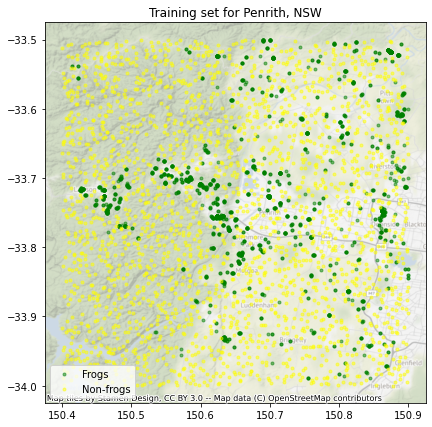

In [8]:
fig, ax = plt.subplots(figsize = (7, 7))

filt = all_frog_data.occurrenceStatus == 1
ax.scatter(all_frog_data[filt].decimalLongitude, all_frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label='Frogs')
ax.scatter(all_frog_data[~filt].decimalLongitude, all_frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label='Non-frogs')
ax.legend()
cx.add_basemap(ax, crs=crs, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

### Getting Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables. Code in this section is adapted from the [Weather](Weather.ipynb) notebook.

#### Fetching TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take six metrics from four assets, namely the mean and overall maximum monthly air temp (`tmax_mean`, `tmax_max`), mean and overall minimum monthly air temp (`tmin_mean`, `tmin_min`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an $(n\times m)$ image. We will choose $(512\times 512)$.


In [9]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [10]:
# Metrics to measure over time dimension
metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean',
       'soil_mean'], dtype='<U9')

#### Visualising the TerraClimate Data

The spatial distribution of the six variables are displayed below.

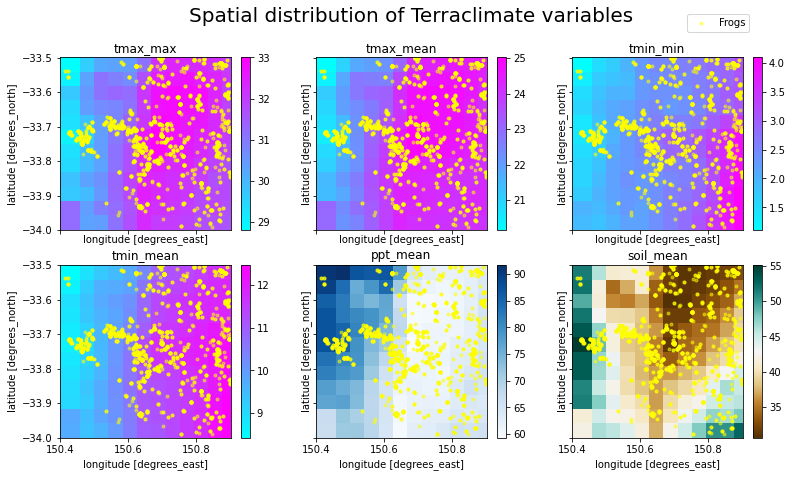

In [11]:
nrow = 2
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = all_frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(all_frog_data[filt].decimalLongitude, all_frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label='Frogs' if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model you decide to train, some of the variables might require normalisation, standardisation, or transformation. For now, we will proceed with the variables as they come.

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

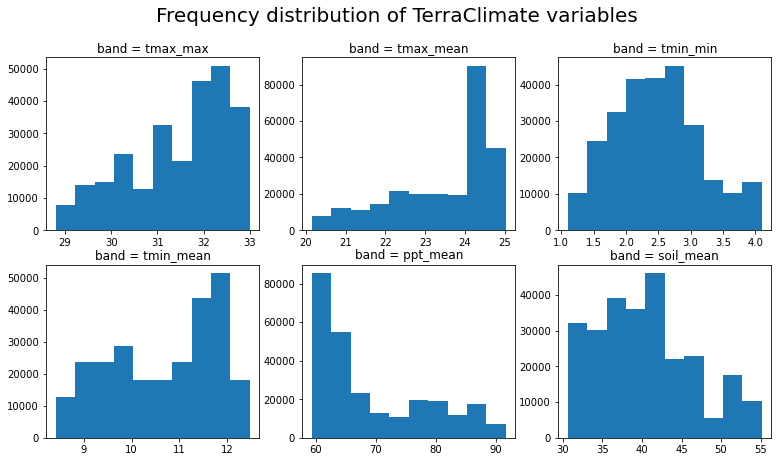

In [12]:
nrow = 2
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values
filt = all_frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol]) #, cmap=cmaps[i], ) 
    # ax[i//ncol, i%ncol].set_title(bands[i])
    # ax[i//ncol, i%ncol].scatter(all_frog_data[filt].decimalLongitude, all_frog_data[filt].decimalLatitude,
                                # color = 'yellow', marker='.', alpha=0.5, label='Frogs' if i==0 else '')

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)
# fig.legend(loc=(0.85, 0.933))

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [13]:
def join_features(model_data, predictor_image):
    """Joins the features from each feature dataset onto each response variable. 

    Arguments:
    model_data -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    all_datasets -- list of feature datasets stored as xarray dataarrays, indexed with geocoordinates
    """
    # For each latitude and longitude coordinate, find the nearest predictor variable pixel values
    data_per_point = pd.DataFrame()
    for j, (lon, lat, key) in enumerate(zip(model_data.decimalLongitude, model_data.decimalLatitude, model_data.key)):
        # Print out some progress markers
        if (j+1)%(len(model_data)//10)==0:
            print(f"{j+1} of {len(model_data)}")

        # Get the predictor pixel at the site of the frog occurrence
        nearest_point = predictor_image.sel(y=lat, x=lon, method="nearest")

        # Prepare values and columns and save them in a dataframe, saving the join key for later reference
        values = np.concatenate((np.squeeze(nearest_point.values), np.array([key])))
        columns = list(nearest_point.band.values) + ['key']
        data_per_point = data_per_point.append(
            pd.DataFrame(
                np.array([values]), 
                columns=columns
            )
        )

    # Join the predictor variables we just collected back onto the frog data
    model_data = model_data.merge(
        data_per_point,
        on = ['key'],
        how = 'inner'
    )
        
    return model_data

model_data = join_features(all_frog_data, weather_data)
model_data.head()

446 of 4462
892 of 4462
1338 of 4462
1784 of 4462
2230 of 4462
2676 of 4462
3122 of 4462
3568 of 4462
4014 of 4462
4460 of 4462


,key,decimalLatitude,decimalLongitude,occurrenceStatus,species,geometry,tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean
0,0,-33.500000,150.700000,1,Crinia signifera,POINT (150.70000 -33.50000),32.200005,24.186668,2.500000,10.926668,64.666664,31.799999
1,1,-33.695343,150.552483,1,Crinia signifera,POINT (150.55248 -33.69534),30.800003,22.721670,2.200001,9.871669,78.966667,40.799999
2,2,-33.708200,150.614000,1,Crinia signifera,POINT (150.61400 -33.70820),31.500000,23.655003,2.500000,10.508335,71.483330,37.916668
3,3,-33.686208,150.534465,1,Crinia signifera,POINT (150.53447 -33.68621),30.400002,22.243336,2.100002,9.571668,81.066666,41.883335
4,4,-33.715400,150.430000,1,Crinia signifera,POINT (150.43000 -33.71540),29.000000,20.506670,1.400002,8.650001,87.316666,55.150002


### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [14]:
full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['key', 'decimalLongitude', 'decimalLatitude', 'occurrenceStatus', 'species', 'geometry'], 1)
)
y = model_data.occurrenceStatus.astype(int)

For now, we will train the model using all of our training data. Hence, this section will only reflect the in-sample performance of our model, and not the out-of-sample performance. Out-of-sample performance is crucial in estimating how a model will generalise to areas other than the training sight. We will attempt to evaluate the out-of-sample performance of this model in a later section, but for now we can have some fun visualising the in-sample performance for the training area.

In [15]:
full_model.fit(X, y)

LogisticRegression()

### Model Prediction

#### Predict Training Set

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To obtain the predictions for our training set, we simply use the `predict` method on our trained model.

In [ ]:
predictions = full_model.predict(X)

#### Predict Entire Region

We also want to perform predictions over the entire region, not just the points in our training set. To do this, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel in the region.

In [16]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    
    # Calculate probability for each pixel point 
    probabilities = model.predict_proba(
        predictor_image
    )

    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]

    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

### Results

Now that we have trained our model and made some predictions, all that is left is to evaluate it. We will do this by first visualising the output of the model with a probability heatmap. Then, we will evaluate both its in-sample and out-of-sample performance using the training set we have generated.

#### In-Sample Evaluation

Now that we have our model predictions for the training set stored in the `predictions` variable, we can calculate some performance metrics to guage the effectiveness of the model. Again, it must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance. Additionally, the training set itself is biased and this notebook made no effort to address this. The model evaluation metrics are only as good as the test data, so the metrics themselves will also be biased. Thus, these metrics are NOT truly indicative of this model's performance.


In [18]:
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}")

F1 Score: 0.69
Accuracy: 0.65


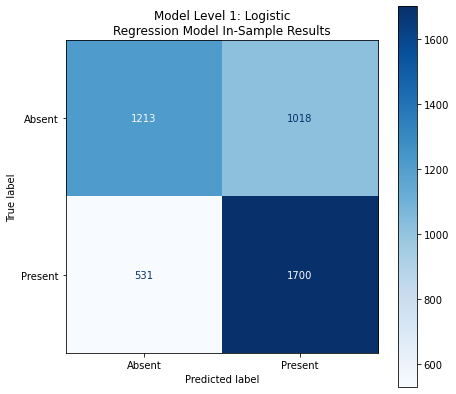

In [19]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

From above, we see that the model is able to achieve a moderately high F1 score and accuracy. However, from the confusion matrix we can see that it gets about half of the absent locations incorrect (false positives). Perhaps we can gain more insight into what is causing the model to do this by visualising the model over the area in question. 

#### Probability Heatmap

To create the probability heatmap, we write a function called `plot_heatmap`. This function will take in the model predictions from the entire region as stored in the `resultant_image` variable, and visualise these probabilities as a heatmap. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the frog occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly.

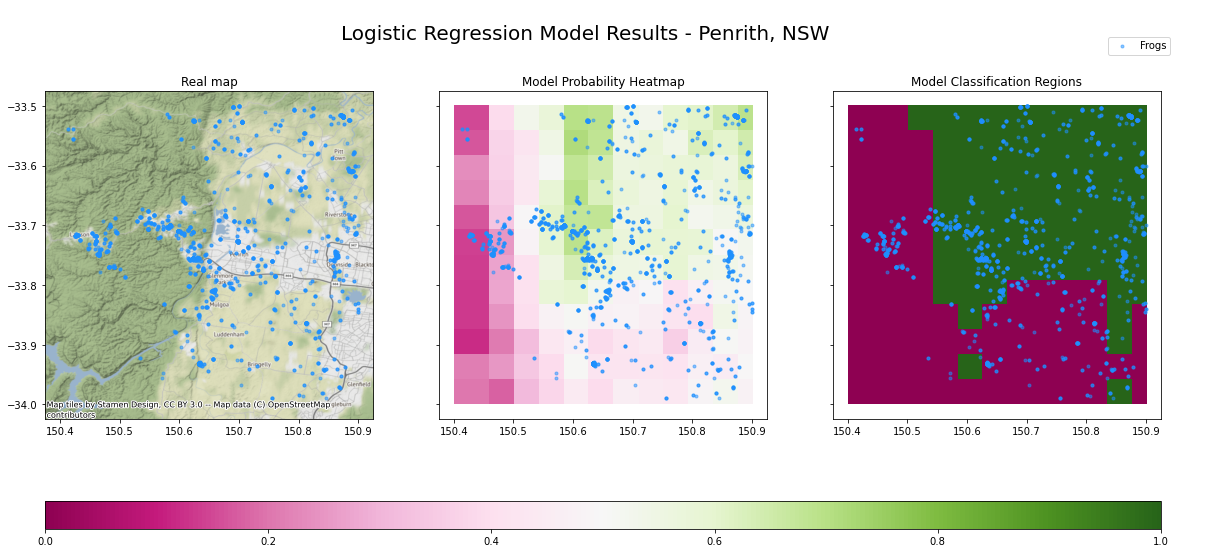

In [17]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    
    bbox = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]

    # Plot real map
    ax[0].scatter(x=[bbox[0], bbox[1]], y=[bbox[2], bbox[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = ax[1].imshow(
        resultant_image, cmap='PiYG', vmin=0, vmax=1.0, interpolation='none', extent=bbox, origin='lower'
    )
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = ax[2].imshow(
        resultant_image > 0.5, cmap='PiYG', vmin=0, vmax=1.0, interpolation='none', extent=bbox, origin='lower'
    )
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Frogs' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
plot_heatmap(resultant_image, all_frog_data, "Logistic Regression Model Results - Penrith, NSW")

From the plots above, we can see that the model is basically dividing the region into two regions of basically equal area. Because the frog absence points are roughly uniformly distributed across the region, the equally sized classification regions accounts for the high rate of false positives seen in the confusion matrix. Additionally, due to the coarse spatial resolution of the TerraClimate data, the classification regions are very blocky. You don't need to be a frog expert to see that this model is quite limited in its ability to identify frog habitats.

#### Out-of-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

`Scikit-learn` has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.

Again, these metrics are derived from a biased sample, so be careful what you infer.


In [20]:
from sklearn.model_selection import StratifiedKFold

cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.67
Accuracy: 0.63


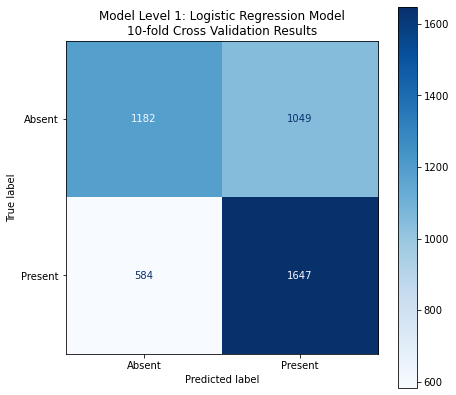

In [21]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic Regression Model\n10-fold Cross Validation Results')
plt.show()

The results from the 10-fold cross validation are similar but slightly lower than the in-sample metrics, as expected. We see similar behavour in the rate of false positives that we saw in the in-sample performance. 

### Get Frogging!

Now that you have witnessed a basic approach to model training, its time to try your own approach! Feel free to modify any of the functions presented in this notebook. Be sure to address some of the assumptions made here, particularly around frog absence sampling to address the sampling bias in the dataset. You might even decide on a completely different training set, such as classifying regions rather than points. Do whatever you think will create the best model for predicting frog habitats. Best of luck!